K-means clustering 2

In [2]:
import pandas as pd
customer = pd.read_csv('https://raw.githubusercontent.com/snkn1959/data_source/main/customer.csv')

In [4]:
customer.head()
#Card Number (ID)
#Purchase Category
#Transaction Amount

,cc_num,category,amt
0,2703186189652095,misc,4.97
1,630423337322,grocery,107.23
2,38859492057661,entertainment,220.11
3,3534093764340240,gas_transport,45.00
4,375534208663984,misc,41.96


In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240454 entries, 0 to 240453
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   cc_num    240454 non-null  int64  
 1   category  240454 non-null  object 
 2   amt       240454 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.5+ MB


In [7]:
customer['cc_num'].nunique()
# Checking the number of unique card numbers.

100

In [8]:
customer['category'].nunique()
# Checking the number of unique purchase categories.

11

In [9]:
# After calculating how much each customer spent in each category, I applied K-means clustering to group customers with similar spending patterns.

In [10]:
customer_dummy = pd.get_dummies(customer, columns = ['category'])
customer_dummy.head()

,cc_num,amt,category_entertainment,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel
0,2703186189652095,4.97,False,False,False,False,False,False,False,True,False,False,False
1,630423337322,107.23,False,False,False,True,False,False,False,False,False,False,False
2,38859492057661,220.11,True,False,False,False,False,False,False,False,False,False,False
3,3534093764340240,45.00,False,False,True,False,False,False,False,False,False,False,False
4,375534208663984,41.96,False,False,False,False,False,False,False,True,False,False,False


In [11]:
# In other words, each category is split into a separate column, where a value of 1 indicates that the entry belongs to that category, and 0 otherwise.
# This transforms the data into a numerical format suitable for algorithms like K-means.

In [12]:
cat_list = customer_dummy.columns[2:]

for i in cat_list:
    customer_dummy[i] = customer_dummy[i] * customer_dummy['amt']

In [13]:
agg = customer_dummy.groupby('cc_num').sum()

In [14]:
agg.head()

,amt,category_entertainment,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel
cc_num,,,,,,,,,,,,
60495593109,48149.62,3169.74,4043.46,5076.36,7576.58,1631.22,5458.58,4924.97,4889.57,3135.25,8106.36,137.53
571365235126,259784.87,13864.51,9055.51,36525.79,48812.73,13685.60,19342.79,17726.82,32542.61,16672.08,45994.60,5561.83
571465035400,270081.63,16162.98,15448.75,9081.62,41643.82,15244.03,28282.98,13737.95,15880.82,8771.27,59454.96,46372.45
630412733309,41959.52,3212.46,1543.16,5786.98,8416.70,3201.04,2474.68,3648.97,3109.83,2592.17,7586.79,386.74
630423337322,244612.73,12786.75,6905.07,36460.40,43854.26,12136.74,21106.87,16807.24,32400.76,15885.32,44287.02,1982.30


In [15]:
mask = (customer['cc_num'] == 630423337322) & (customer['category'] == 'grocery')
expected_total = customer.loc[mask, 'amt'].sum()
print(f"수동 계산한 grocery 총 금액: {expected_total}")

computed_total = agg.loc[630423337322, 'category_grocery']
print(f"K-means용으로 만든 agg 테이블의 grocery 금액: {computed_total}")

수동 계산한 grocery 총 금액: 43854.26
K-means용으로 만든 agg 테이블의 grocery 금액: 43854.26


In [16]:
diff = customer_dummy.copy()

customer_check = pd.get_dummies(customer, columns=['category'])
cat_cols = customer_check.columns[2:-1]  # category 열들 추출 (amt 제외)

for col in cat_cols:
    customer_check[col] = customer_check[col] * customer_check['amt']

check_agg = customer_check.groupby('cc_num')[cat_cols].sum()

difference = agg[cat_cols] - check_agg
print("차이 있는 값 개수:", (difference.abs() > 1e-6).sum().sum())  # 0이면 정확히 일치

차이 있는 값 개수: 0


KNN and K-means clustering are distance-based algorithms, so they are sensitive to the scale of the data. Therefore, I applied scaling using the StandardScaler.

In [17]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

scaled = pd.DataFrame(sc.fit_transform(agg), columns = agg.columns,\
                     index = agg.index)

In [18]:
scaled.head()

,amt,category_entertainment,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel
cc_num,,,,,,,,,,,,
60495593109,-1.402327,-1.135617,-0.971069,-1.000180,-1.118217,-1.561756,-1.145051,-1.276913,-1.124693,-1.070260,-1.141424,-0.619930
571365235126,1.079407,0.414075,0.168880,2.090013,0.767268,1.040236,0.844969,1.127922,1.210503,1.807350,0.659967,-0.222587
571465035400,1.200151,0.747127,1.622968,-0.606627,0.439476,1.376630,2.126364,0.378610,-0.196523,0.127825,1.299938,2.766891
630412733309,-1.474915,-1.129427,-1.539741,-0.930355,-1.079803,-1.222903,-1.572733,-1.516610,-1.274986,-1.185705,-1.166127,-0.601675
630423337322,0.901491,0.257905,-0.320220,2.083588,0.540547,0.705908,1.097814,0.955178,1.198524,1.640103,0.578781,-0.484796


In [22]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

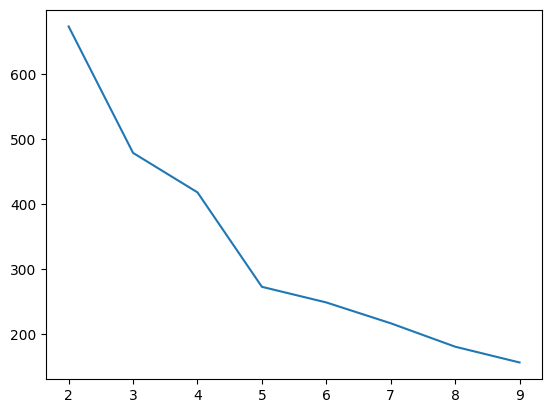

In [23]:
distance = []

for k in range(2,10):
    md = KMeans(n_clusters = k)
    md.fit(scaled)
    labels = md.predict(scaled)
    distance.append(md.inertia_)

sns.lineplot(x = range(2,10), y = distance)

The graph gradually decreases without a sharp drop at any specific point, making it difficult to determine the optimal K value.

**-Solution: Silhouette Coefficient**

This metric considers both the average distance within a cluster and the average distance to the nearest neighboring cluster when calculating the score. It serves as an alternative to the elbow method for identifying the optimal number of clusters.

In [24]:
from sklearn.metrics import silhouette_score

s = []

for k in range(2,10):
    md = KMeans(n_clusters = k)
    md.fit(scaled)
    labels = md.predict(scaled)
    s.append(silhouette_score(scaled, labels))

<Axes: >

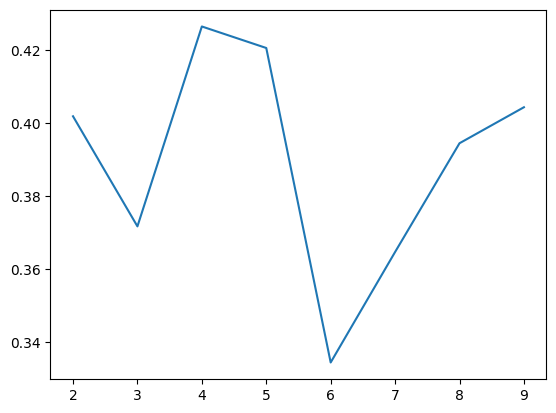

In [25]:
sns.lineplot(x = range(2,10), y = s)

In [26]:
md = KMeans(n_clusters = 4)
md.fit(scaled)
labels = md.predict(scaled)
labels

array([0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 3, 0, 3, 2,
       3, 0, 1, 0, 2, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0,
       3, 2, 1, 0, 3, 1, 0, 3, 2, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 0, 2,
       3, 0, 3, 3, 0, 0, 3, 1, 3, 0, 1, 0, 0, 0, 0, 3, 3, 0, 0, 3, 2, 3,
       0, 1, 3, 0, 0, 0, 3, 1, 0, 0, 0, 1], dtype=int32)

In [27]:
scaled['label'] = labels

In [28]:
scaled_mean = scaled.groupby('label').mean()
scaled_count = scaled.groupby('label').count()['category_travel']

In [29]:
scaled_count = scaled_count.rename('count')

In [30]:
scaled = scaled_mean.join(scaled_count)
scaled

,amt,category_entertainment,category_food_dining,category_gas_transport,category_grocery,category_health_fitness,category_home,category_kids_pets,category_misc,category_personal_care,category_shopping,category_travel,count
label,,,,,,,,,,,,,
0,-0.901958,-0.764983,-0.783699,-0.656687,-0.677806,-0.900760,-0.868026,-0.915129,-0.722170,-0.793534,-0.732325,-0.285396,42
1,0.802017,0.502568,0.272467,1.822572,0.343507,0.960828,0.768643,1.205174,0.951714,0.951892,0.416040,-0.224286,13
2,2.246930,2.636017,2.102489,-0.339554,2.553883,1.526188,1.118452,1.527483,2.410239,2.042583,2.581577,-0.269260,7
3,0.308619,0.187994,0.385680,0.164849,0.161186,0.385732,0.490409,0.317783,0.028610,0.175151,0.191529,0.441768,38


from matplotlib import pyplot as plt
scaled['amt'].plot(kind='hist', bins=20, title='amt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_entertainment'].plot(kind='hist', bins=20, title='category_entertainment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_food_dining'].plot(kind='hist', bins=20, title='category_food_dining')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_gas_transport'].plot(kind='hist', bins=20, title='category_gas_transport')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled.plot(kind='scatter', x='amt', y='category_entertainment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled.plot(kind='scatter', x='category_entertainment', y='category_food_dining', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled.plot(kind='scatter', x='category_food_dining', y='category_gas_transport', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled.plot(kind='scatter', x='category_gas_transport', y='category_grocery', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
scaled['amt'].plot(kind='line', figsize=(8, 4), title='amt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_entertainment'].plot(kind='line', figsize=(8, 4), title='category_entertainment')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_food_dining'].plot(kind='line', figsize=(8, 4), title='category_food_dining')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
scaled['category_gas_transport'].plot(kind='line', figsize=(8, 4), title='category_gas_transport')
plt.gca().spines[['top', 'right']].set_visible(False)

Cluster 0 (42 customers)
Negative z-scores for total spending (amt) and all categories → indicates overall low spending.

Particularly low in health, home, kids_pets, and misc categories.

👉 Budget-conscious customer group with generally minimal expenditures

Cluster 1 (13 customers)
Very high spending in gas_transport (z = +1.82).

Also shows relatively high values in misc, personal_care, and shopping.

👉 Customers with concentrated spending in specific categories, especially transportation, but overall with no strong defining pattern.

👉 Typical consumer group with moderate behavior.

Cluster 2 (7 customers)
Extremely high z-scores across almost all categories, including entertainment, grocery, shopping, and personal_care (many above +2).

Highest overall spending (amt) with a z-score of +2.25.

👉 VIP customer segment, representing the top 10% of high spenders across nearly all categories.

👉 Highly valuable, premium consumer group.

Cluster 3 (38 customers)
Most categories are near average (z ≈ 0), indicating typical spending levels.

Slightly elevated spending in travel (z = +0.44), and moderately higher in health, home as well.

👉 Travel-oriented customer group with otherwise average consumption.

👉 General consumers with specific interest in travel-related expenses.